In [1]:
from datetime import datetime
from glob import glob
import json
import os

import cv2
from keras import losses, Model, optimizers, metrics
# from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, DepthwiseConv2D, Dropout, Flatten, Input, Reshape
# from keras.losses import SparseCategoricalCrossentropy
# # from keras.metrics import MeanSquaredError, SparseCategoricalAccuracy
# from keras.utils import plot_model
# from livelossplot import PlotLossesKeras, PlotLossesKerasTF
# from matplotlib import pyplot as plt
# from numpy import interp
# import numpy as np
# import pandas as pd
# from PIL import Image
# from sklearn.preprocessing import label_binarize
# import tensorflow as tf
# import tensorflow.keras as k
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.python.ops.image_ops_impl import *

from FUNCTIONS.dataset_mkr import *
from FUNCTIONS.eval_function import *
from FUNCTIONS.gpu_memory import *
from FUNCTIONS.model import *
from FUNCTIONS.model_visualizer import *

2022-11-08 15:26:55.273768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 15:26:55.412428: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 15:26:56.074890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-08 15:26:56.074946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [2]:
# load tensorboard
%load_ext tensorboard


In [3]:
"""
0 CPU
1 필요한 만큼 메모리를 런타임에 할당
2 GPU에 할당되는 전체 메모리 크기를 제한
"""
set_gpu_memory(1)

1 Physical GPUs, 1 Logical GPUs


2022-11-08 15:26:57.166767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 15:26:57.171088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 15:26:57.171339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 15:26:57.172016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
DEBUG = 1
TENSORBOARD = 1
SAVE = 1

MIN, MAX = 0, 255


# 1. DATASET

In [5]:
# data_dir = f"/media/z/0/MVPC10/DATA/v1.1/RAW/03"
# file = f"label_1248_cnt.csv"
# file = f"/media/z/0/MVPC10/CODE/pplcnt_model/LABEL/labeled_refined.csv"
file = f"/media/z/0/MVPC10/DATA/LABEL/v2.2_label.csv"
df = pd.read_csv(file)
# df.sort_values(by=df.keys()[0], inplace=True, ascending=True)
df.head


<bound method NDFrame.head of                 path                                              label
0      1650315736806                                     [[0, 0, 0, 0]]
1      1650315796123                                     [[0, 0, 0, 0]]
2      1650315856514                                     [[0, 0, 0, 0]]
3      1650315917006                                     [[0, 0, 0, 0]]
4      1650315976418                                     [[0, 0, 0, 0]]
...              ...                                                ...
86493  1661954116964  [[31, 49, 40, 69], [38, 43, 46, 64], [48, 51, ...
86494  1661954176336                                     [[0, 0, 0, 0]]
86495  1661954236769                                     [[0, 0, 0, 0]]
86496  1661954296445               [[25, 33, 34, 49], [31, 24, 35, 36]]
86497  1661954356730                                 [[23, 33, 34, 47]]

[86498 rows x 2 columns]>

In [6]:
df.empty

False

In [7]:
df.dtypes

path      int64
label    object
dtype: object

### remoce all exceptiona

In [8]:
# df[df.iloc[:,1] < 1]
# df.iloc[:,1]
# print(np.where(df[0] > 0))

### LABEL

In [9]:
import csv


S1, S2 = 80, 80

def dot_mkr(s1, s2, x, y):
    li = []
    for i in range(x//2, s1, x):
        for j in range(y//2, s2, y):
            li.append([i, j])
    return li


dot_list = dot_mkr(S1, S2, 4, 4)
print(f"len dot_list: {len(dot_list)}")
# print(dot_list)

with open('dot_44.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['x','y'])
    write.writerows(dot_list)


len dot_list: 400


In [10]:
# def bbox2dot(dataframe, z_value):
#     cnt0 = 0
#     path = []
#     label = []
#     for i in range(len(dataframe.index)):
#         tmp = []
#         for j in json.loads(dataframe.iloc[i, 1]):
#             try:
#                 if len(j) == 4:
#                     x = j[2]-((j[2]-j[0])/2)
#                     y = j[3]-((j[3]-j[1])/2)
#                     tmp.append([x, y])
#             except Exception as E:
#                 pass
#         if len(tmp) > 0:
#             if 0 in tmp[0]:
#                 cnt0 += 1
#                 if cnt0%z_value == 0:
#                     path.append(dataframe.iloc[i, 0])
#                     label.append(tmp)
#                     cnt0 = 0
#             else:
#                 path.append(dataframe.iloc[i, 0])
#                 label.append(tmp)
#     path = np.array(path)
#     label = np.array(label)
#
#     df = pd.DataFrame(list(zip(path, label)), columns=['path', 'label'])
#
#     return df


In [ ]:
dot_df = v2_2_data_mkr(df, 40)
dot_df.head

In [12]:
# for i in range(len(dot_df)):
#     if len(dot_df.iloc[i,1]) == 0:
#         print(0)

In [13]:
def label_mkr(data):
    """in: raw label, out: padded label"""
    label = []
    for r in data:
        li = []
        for d in dot_list:
            dis1 = abs(r[0]-d[0])
            dis2 = abs(r[1]-d[1])
            li.append(dis1+dis2)
        # mn = li.index(min(li))
        dis, idx = li[0], 0
        for i in range(0, len(li)):
            if li[i] < dis:
                dis = li[i]
                idx = i
        label.append(idx)

    return label

In [14]:
label_li = []
for i in range(0, len(dot_df)):
    label = label_mkr(dot_df.iloc[i,1])
    label_li.append(label)

In [15]:
# label_li[3000:3600]

In [16]:
label_li[0]

[148]

In [17]:
label_padding = np.zeros([len(dot_df),400,1], dtype=int)
label_padding.shape

(52671, 400, 1)

In [18]:
for idx, ele in enumerate(label_li):
    for e in ele:
        label_padding[idx, e] = 1

label_padding.shape

(52671, 400, 1)

### post process label

In [19]:
label_padding[8900, 0]

array([0])

In [20]:
## remove all ones in first place
for i in range(len(label_padding)):
    label_padding[i,0] = 0

In [21]:
label_padding[8900,0]


array([0])

In [22]:
sh1 = int(np.sqrt(label_padding.shape[1]))
label1 = np.reshape(label_padding, (label_padding.shape[0], sh1, sh1, 1))
# label1 = np.reshape(label_padding, (label_padding.shape[0], sh1, sh1))

label1.shape
# label1[36]

(52671, 20, 20, 1)

In [23]:
ind = 36

print(label_li[ind])
print(np.where(label_padding[ind] > 0))

[149, 147]
(array([147, 149]), array([0, 0]))


### DATA

In [24]:
df1 = dot_df.iloc[:,0]
df1.head

<bound method NDFrame.head of 0        1650317656374
1        1650317716924
2        1650317776334
3        1650317836858
4        1650317896295
             ...      
52666    1661953996801
52667    1661954056432
52668    1661954116964
52669    1661954296445
52670    1661954356730
Name: path, Length: 52671, dtype: int64>

In [25]:
# PATH TO REAL_PATH
img_dir = f"/media/z/0/MVPC10/DATA/03_PROCESSED"
for i in range(len(df1)):
    df1.iloc[i] = f"{img_dir}/{df1.iloc[i]}.png"
df1.head


/tmp/ipykernel_52991/3188519729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.iloc[i] = f"{img_dir}/{df1.iloc[i]}.png"


<bound method NDFrame.head of 0        /media/z/0/MVPC10/DATA/03_PROCESSED/1650317656...
1        /media/z/0/MVPC10/DATA/03_PROCESSED/1650317716...
2        /media/z/0/MVPC10/DATA/03_PROCESSED/1650317776...
3        /media/z/0/MVPC10/DATA/03_PROCESSED/1650317836...
4        /media/z/0/MVPC10/DATA/03_PROCESSED/1650317896...
                               ...                        
52666    /media/z/0/MVPC10/DATA/03_PROCESSED/1661953996...
52667    /media/z/0/MVPC10/DATA/03_PROCESSED/1661954056...
52668    /media/z/0/MVPC10/DATA/03_PROCESSED/1661954116...
52669    /media/z/0/MVPC10/DATA/03_PROCESSED/1661954296...
52670    /media/z/0/MVPC10/DATA/03_PROCESSED/1661954356...
Name: path, Length: 52671, dtype: object>

In [26]:

## GET H,W
sample_img = Image.open(df1.iloc[16])
img_array = np.array(sample_img, int)
H, W = img_array.shape

H, W

(80, 80)

In [27]:
## SHUFFLE
# df = df.sample(frac=1).reset_index(drop=True)
# df

In [28]:
## DROP ERROR
# df1 = df[df.iloc[:, 2] > 0]
# df1


### PRE-PROCESS

In [29]:
# label_padding

In [30]:
## DATASET TO TENSOR
data = []
for i in range(len(dot_df)):
    try:
        img = Image.open(df1[i])
        img = data.append(list(img.getdata()))
    except Exception as E:
        log(DEBUG, E)
    if i%10000 == 0:  print(i)

data = np.array(data)
data = data.reshape(data.shape[0], H, W, 1)

log(DEBUG, data.shape)
log(DEBUG, label1.shape)


0
10000
20000
30000
40000
50000
(52671, 80, 80, 1)
(52671, 20, 20, 1)


In [31]:
# label1[36] > 0


In [32]:
# ## Shuffle
# seed = 99
# np.random.seed(seed)
# np.random.shuffle(data)
# # np.random.seed(seed)
# np.random.shuffle(label)


## Nomalize
# log(DEBUG, data[0][0])
norm_data = data/MAX
# norm_data = data.astype("float")/MAX
# log(DEBUG, norm_data[0][0])

label = label1
# label = label_padding
# label = np.reshape(label, (label_padding.shape[0],label_padding.shape[1]))

## TEST SPLIT
split1 = int(len(label)*0.9)
X1, X2 = norm_data[:split1], norm_data[split1:]
Y1, Y2 = label[:split1], label[split1:]
## VAL SPLIT
split2 = int(len(label)*0.9)
# train_data, val_data = train_data[:split2], train_data[split2:]
# train_label, val_label = train_label[:split2], train_label[split2:]


In [33]:
print(X1.shape)
print(Y1.shape)

(47403, 80, 80, 1)
(47403, 20, 20, 1)


# 2. TRAIN

In [34]:
LOAD_MODEL = 0
MODEL_VERSION = f"v2.2"

if LOAD_MODEL == 0:
    ## ---------------------------------------------------------------- SETUP
    inc = make_inc()
    # size = input_shape - layer_shape + 1
    ## con(filter, (size), stride, padding, activation, name, input)

    ## ---------------------------------------------------------------- IN
    input = Input(shape=(H, W, 1))

    ## ---------------------------------------------------------------- HEAD
    x = con(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', input)

    ## ---------------------------------------------------------------- BODY
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 3, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 5, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 7, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    x = res(64, 9, 1, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res(64, 3, 2, 'valid', 'elu', 0.25, f'{inc()}', x)
    # x = res(64, 5, 2, 'valid', 'elu', 0.25, f'{inc()}', x)

    ## ---------------------------------------------------------------- TAIL
    x = Conv2D(1, 11, strides=2, name=f'{inc()}')(x)
    # x = tf.reduce_mean(x, (1, 2))  #, axis=None, keepdims=False, name=None)
    # x = Dropout(.5)(x)

    ## ---------------------------------------------------------------- OUT
    output = Conv2D(1, 3, strides=1, name=f'{inc()}')(x)

    model = Model(input, output)

    ## ---------------------------------------------------------------- OPTIMIZER
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #         initial_learning_rate=0.001,
    #         decay_steps=100000,
    #         decay_rate=0.96,
    #         staircase=True)

    # lr_schedule = k.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4,
    #                                                  decay_steps=EPOCH,
    #                                                  )

    # optimizer = optimizers.Adam(learning_rate=lr_schedule)
    optimizer = optimizers.Adam(learning_rate=0.0001)

    ## ---------------------------------------------------------------- LOSS
    # def adaptive_loss():
    #     pass
    # loss = losses.MeanAbsoluteError()
    # loss = losses.BinaryCrossentropy()
    # loss = losses.MeanSquaredError()
    # loss = losses.SparseCategoricalCrossentropy()
    loss = losses.BinaryFocalCrossentropy(#apply_class_balancing=False,
                                          # alpha=0.25,
                                          gamma=2.0,
                                          # from_logits=False,
                                          # label_smoothing=0.0,
                                          # axis=-1,
                                          # reduction=losses_utils.ReductionV2.AUTO,
                                          # name='binary_focal_crossentropy'
                                          )

    ## ---------------------------------------------------------------- METRICS
    metrics = ['accuracy']
    # metrics = [SparseCategoricalAccuracy]
    # metrics = [metrics.MeanSquaredError()]

    ## ---------------------------------------------------------------- COMPILE
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


elif LOAD_MODEL == 1:
    model_path_last = glob(f"OUT/{MODEL_VERSION}/model/*.h5")[-1]
    model_path = f"OUT/{MODEL_VERSION}/model/20221024-191637.h5"
    model = tf.keras.models.load_model(model_path_last)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 1)]       0         
                                                                 
 1_C2 (Conv2D)               (None, 78, 78, 64)        640       
                                                                 
 1_BN (BatchNormalization)   (None, 78, 78, 64)        256       
                                                                 
 1_ACT (Activation)          (None, 78, 78, 64)        0         
                                                                 
 1_DO (Dropout)              (None, 78, 78, 64)        0         
                                                                 
 2_C2 (Conv2D)               (None, 76, 76, 64)        36928     
                                                                 
 2_0_BN (BatchNormalization)  (None, 76, 76, 64)       256   


### START

In [35]:
EPOCH = 16
BATCH = 32
ES = EPOCH//4

## fit
log_path = "logs/"+datetime.now().strftime("%Y%m%d-%H%M%S")
es = EarlyStopping(monitor="val_loss", patience=ES, verbose=2, mode='auto')
tensorboard_callback = TensorBoard(log_dir=log_path, histogram_freq=1)

history = model.fit(X1, Y1,
                    validation_split=0.1,
                    # validation_data=(val_data, val_label),
                    batch_size=BATCH,
                    epochs=EPOCH,
                    verbose=1,
                    # callbacks=[es],)
                    callbacks=[es,
                               tensorboard_callback,
                               PlotLossesKeras(),
                               # PlotLossesKerasTF(),
                               ],
                    )

2022-11-08 15:27:40.512539: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-08 15:27:40.512554: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2022-11-08 15:27:40.512580: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2022-11-08 15:27:40.512768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/z/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-08 15:27:40.647975: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-11-08 15:27:40.648119: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/32


2022-11-08 15:27:43.728692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-08 15:27:44.201464: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-08 15:27:44.202342: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-11-08 15:27:44.202354: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-11-08 15:27:44.202391: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

   1/1334 [..............................] - ETA: 3:08:07 - loss: 16.3394 - accuracy: 0.6212

2022-11-08 15:27:50.335978: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2022-11-08 15:27:50.335995: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1334 [..............................] - ETA: 12:59 - loss: 15.2043 - accuracy: 0.6427  

2022-11-08 15:27:50.846129: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-11-08 15:27:50.846510: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2022-11-08 15:27:50.872848: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:521]  GpuTracer has collected 581 callback api events and 606 activity events. 
2022-11-08 15:27:50.878669: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2022-11-08 15:27:50.884933: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/20221108-152740/train/plugins/profile/2022_11_08_15_27_50

2022-11-08 15:27:50.890724: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/20221108-152740/train/plugins/profile/2022_11_08_15_27_50/1.trace.json.gz
2022-11-08 15:27:50.913910: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating direc

1334/1334 [==============================] - 199s 143ms/step - loss: 0.4822 - accuracy: 0.9707 - val_loss: 0.5453 - val_accuracy: 0.9941
Epoch 2/32
1334/1334 [==============================] - 175s 131ms/step - loss: 0.1853 - accuracy: 0.9742 - val_loss: 0.1802 - val_accuracy: 0.9941
Epoch 3/32
1334/1334 [==============================] - 175s 131ms/step - loss: 0.1073 - accuracy: 0.9759 - val_loss: 0.0929 - val_accuracy: 0.9942
Epoch 4/32
1334/1334 [==============================] - 186s 140ms/step - loss: 0.0374 - accuracy: 0.9901 - val_loss: 0.2468 - val_accuracy: 0.9942
Epoch 5/32
1334/1334 [==============================] - 184s 138ms/step - loss: 0.0383 - accuracy: 0.9888 - val_loss: 0.1109 - val_accuracy: 0.9942
Epoch 6/32
1334/1334 [==============================] - 180s 135ms/step - loss: 0.0348 - accuracy: 0.9894 - val_loss: 0.0997 - val_accuracy: 0.9942
Epoch 7/32
1334/1334 [==============================] - 179s 134ms/step - loss: 0.0230 - accuracy: 0.9921 - val_loss: 0.028

In [36]:
# BATCH = 32
# EPOCH = 30
#
# lb = test_label.reshape(-1)
# has = {}
#
# # np.array(list(set(test_label.reshape(-1)))).astype(np.int64)
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
# for ind in range(len(lb)):
#     # ind는 label 인덱스
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# x_data = []
# y_data = []
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(test_data[ind])
#         y_data.append(test_label[ind])
#
# x_data = np.array(x_data).astype(np.float32)
# y_data = np.array(y_data).astype(np.float32)
# train_data = train_data.astype(np.float32)
# train_label = train_label.astype(np.float32)
#
# for i in range(30):
#     print(i)
#     history = model.fit(train_data, train_label,
#                         # validation_split=0.2,
#                         validation_data=(x_data, y_data),
#                         batch_size=BATCH,
#                         epochs=EPOCH,
#                         verbose=1,
#                         # callbacks=[es],)
#                         # callbacks=[es, tensorboard_callback], )
#                         )
#     model.save('asdf/' + str(i) + '.h5')

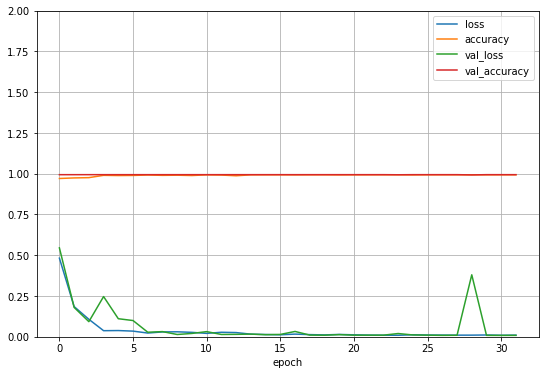

In [37]:
## history to DF
hdf = pd.DataFrame(history.history)
hdf.keys()

## plot history
hdf.plot(figsize=(9, 6), grid=1, xlabel="epoch", label="accuracy")
plt.ylim([0, 2])
plt.show()


In [38]:

# df = px.data.gapminder().query("continent=='Oceania'")
# fig = px.line(hdf, x=hdf.index, y=hdf.values, color=hdf.keys())
# fig.show()


In [39]:
# epo = 10
# model = tf.keras.models.load_model('asdf/' + str(epo) + '.h5')
# test_label.shape
#
# lb = test_label.reshape(-1)
# has = {}
#
# # np.array(list(set(test_label.reshape(-1)))).astype(np.int64)
#
#
# ls_num = list(map(int, list(set(lb))))
# for n in ls_num:
#     has[n] = []
#
# for ind in range(len(lb)):
#
#     # ind는 label 인덱스
#
#     if len(has[lb[ind]]) < 30:
#         has[lb[ind]].append(ind)
#
# ls_num
#
# x_data = []
# y_data = []
#
#
# for key in has.keys():
#     for ind in has[key]:
#         x_data.append(test_data[ind])
#         y_data.append(test_label[ind])
#
# x_data = np.array(x_data)
# y_data = np.array(y_data)
# x_data.shape
# y_data.shape
#
#
# result = np.argmax(model.predict(x_data), -1)
# cont = 0
# for ind in range(len(result)):
#     if result[ind] == y_data.reshape(-1)[ind]:
#         cont +=1
#
#
# cont
# print(len(ls_num))
# print(cont/len(result))



In [40]:
# for i in range(10):
#     num = i
#     size = 10
#     interpolation = cv2.INTER_NEAREST  ## CUBIC LINEAR AREA
#
#     img = test_data[num].reshape(60,48)
#
#     img = np.around(img*255)
#
#     img = img.astype(np.uint8)
#
#     img = cv2.resize(img, (img.shape[1]*size, img.shape[0]*size), interpolation=interpolation)
#
#     img = Image.fromarray(img)
#
#     print(i)
#     display(img)


# 3. EVALUATE

In [42]:
loss, acc = model.evaluate(X2, Y2, verbose=1)

predict = model.predict(X2)

165/165 [==============================] - 6s 32ms/step


In [ ]:
# launch tensorboard @ localhost:6006
if TENSORBOARD == 1:
    %tensorboard --logdir logs/--host localhost --port 6006


In [43]:
SAVE_MODEL = 1
if SAVE_MODEL == 1:
    model_save_name = f"OUT/{MODEL_VERSION}/model/{datetime.now().strftime('%Y%m%d-%H%M%S')}.h5"
    model.save(model_save_name)

In [44]:
predict_shaped = np.reshape(predict, (predict.shape[0], predict.shape[1]*predict.shape[2]))
Y2_shaped = np.reshape(Y2, (Y2.shape[0], Y2.shape[1]*Y2.shape[2]))
# predict_shaped = np.reshape(predict, (predict.shape[0], predict.shape[1]))
# Y2_shaped = np.reshape(Y2, (Y2.shape[0], Y2.shape[1]))

n = 10
print(f"pred:{chr(10)}{predict_shaped[:n]}{chr(10)}")
print(f"label:{chr(10)}{Y2_shaped[:n]}")


pred:
[[-0.01317578 -0.00210732  0.034599   ...  0.04753396  0.07047205
   0.07723071]
 [-0.00323738  0.00977756  0.04819328 ...  0.02197529  0.0483479
   0.06202618]
 [ 0.00489257  0.01367923  0.04505027 ...  0.01716353  0.04537356
   0.06202206]
 ...
 [-0.0111731  -0.00719795  0.01927926 ...  0.03903778  0.04178099
   0.0404501 ]
 [-0.01685734 -0.01391073  0.00822405 ...  0.01453926  0.01734987
   0.01748456]
 [-0.0161613  -0.00718161  0.02577612 ...  0.06874984  0.05365433
   0.03734091]]

label:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# predict = model.predict(train_data)
#
# draw_CM(train_label, predict)
# predict[0]
# Y2_shaped.shape


In [ ]:
## CM
# draw_CM(Y2, predict)

## ROC, AUC
# x = label_binarize(predicted, classes=CLASS)
# y = label_binarize(Y2, classes=CLASS)
# draw_ROC_AUC(x, y, CLASS)

In [ ]:
indx = 623
print(np.where(predict[indx] > 0.35))
print(np.where(Y2[indx] > 0))

In [45]:

ind = np.argpartition(predict, -4)[-4:]
print(ind)

top4 = predict[ind]
print(top4)

# sorted_index_array = np.argsort(predict_shaped)
# sorted_array = predict_shaped[sorted_index_array]

# n = 3
# rslt = sorted_array[-n:]
# print(f"{rslt} largest value:")

ValueError: kth(=-3) out of bounds (1)

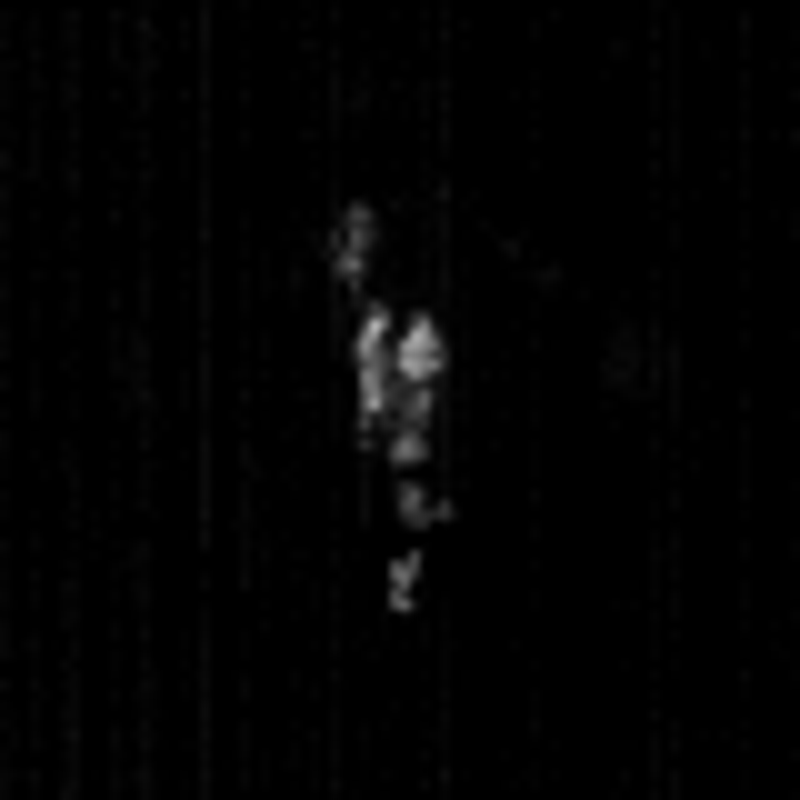

predicted:

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.1 

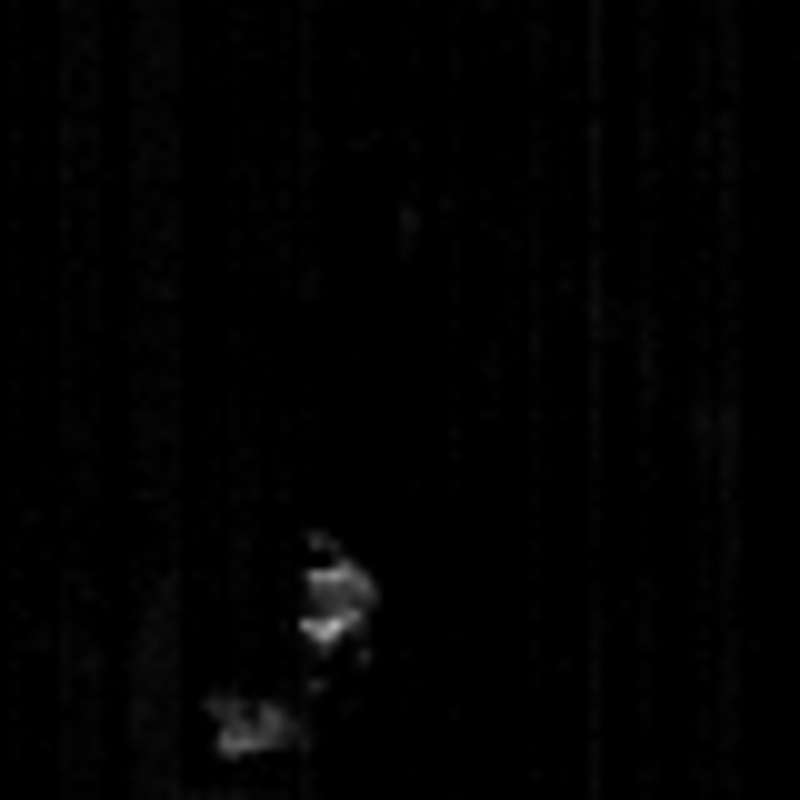

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.

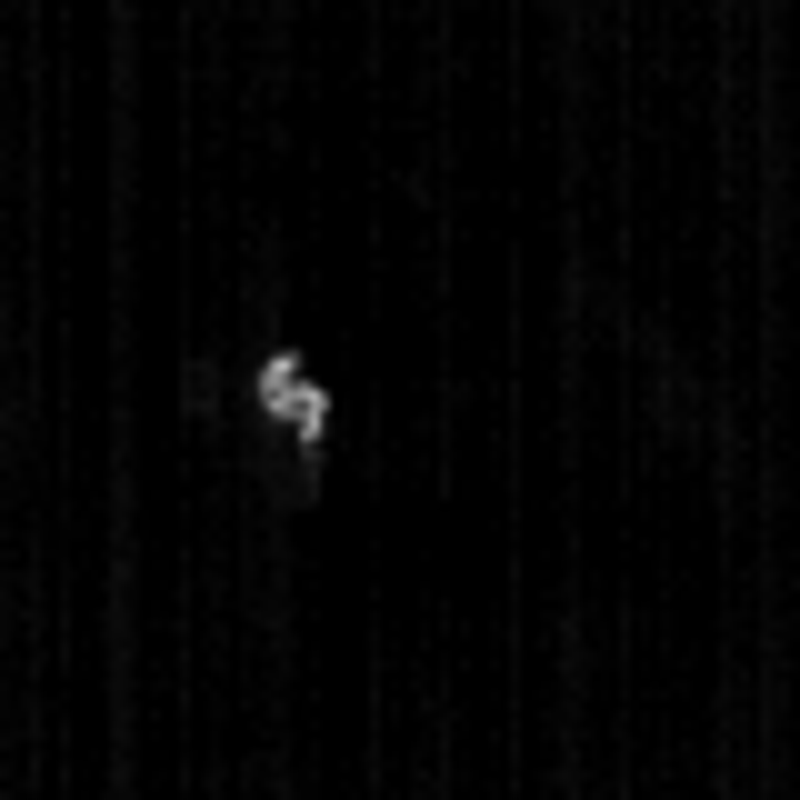

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1

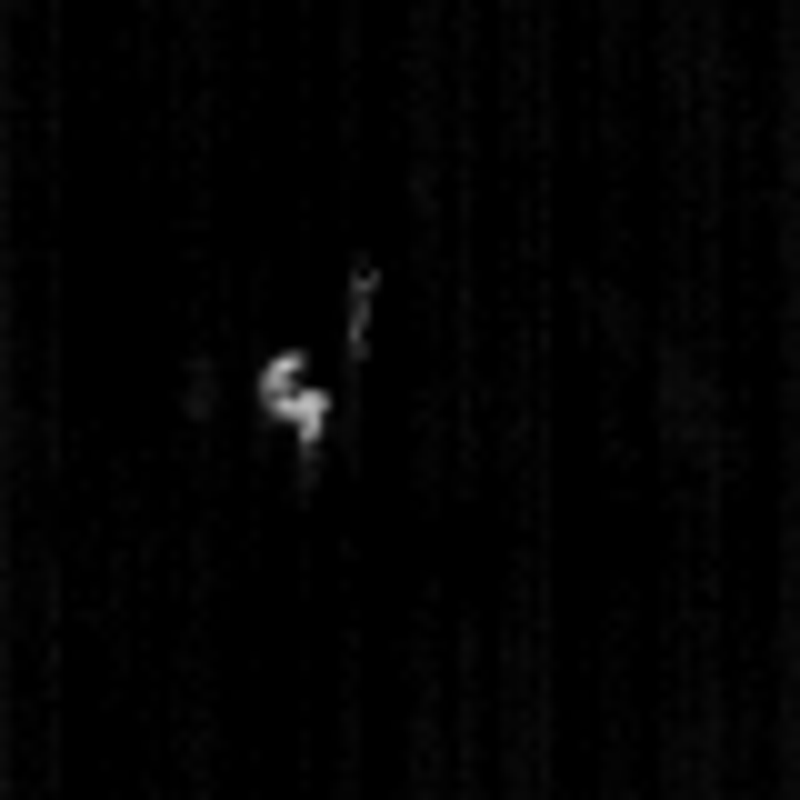

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 

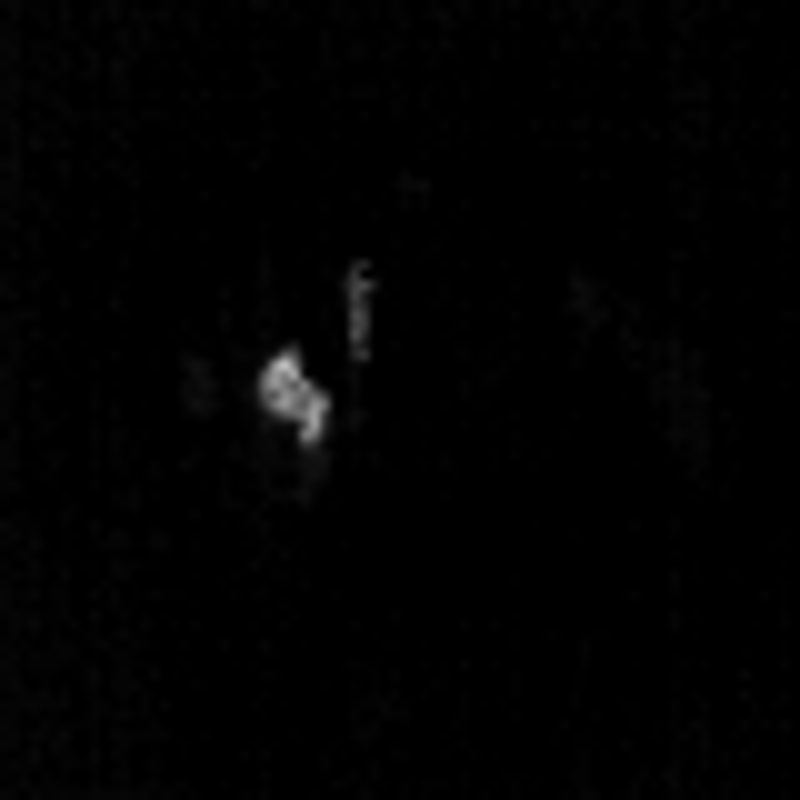

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0

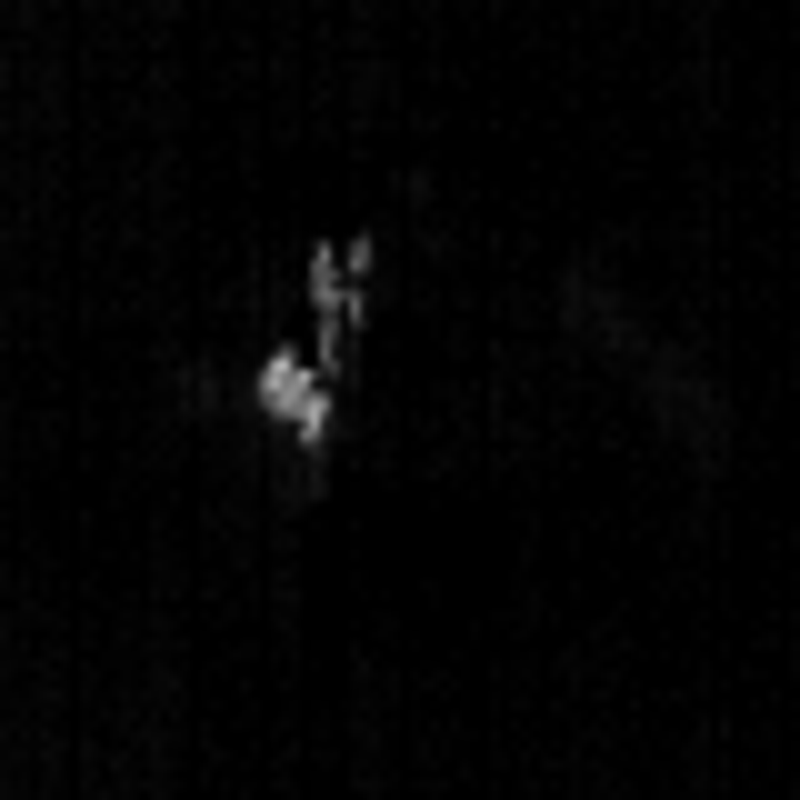

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.1 0.1
 0.1 0.1]
[0.  0.  0.  0.1 0.1 0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  

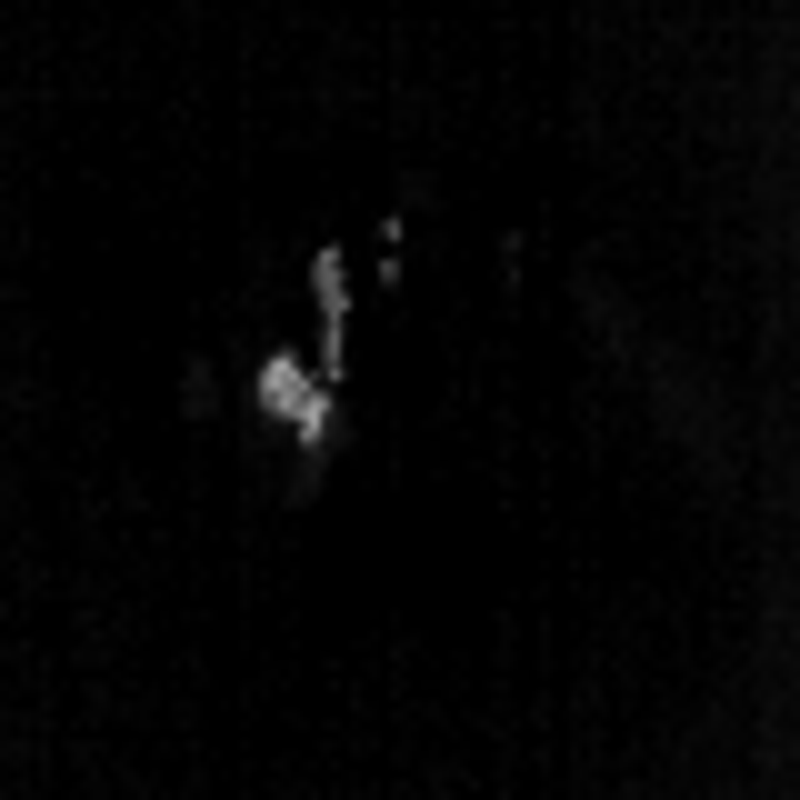

predicted:

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1
 0.1 0. ]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.  0.  0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0

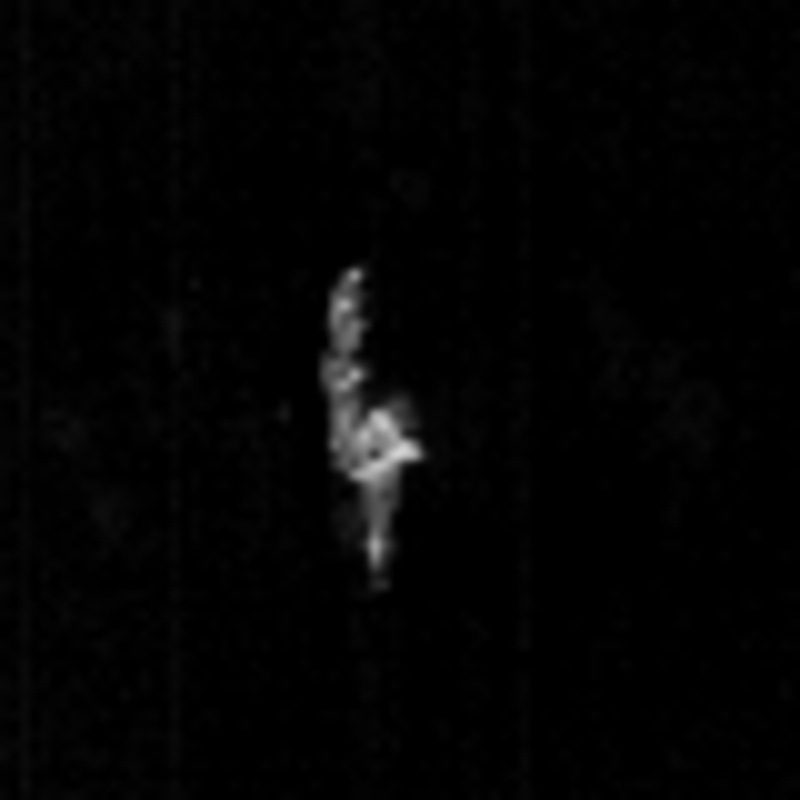

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0

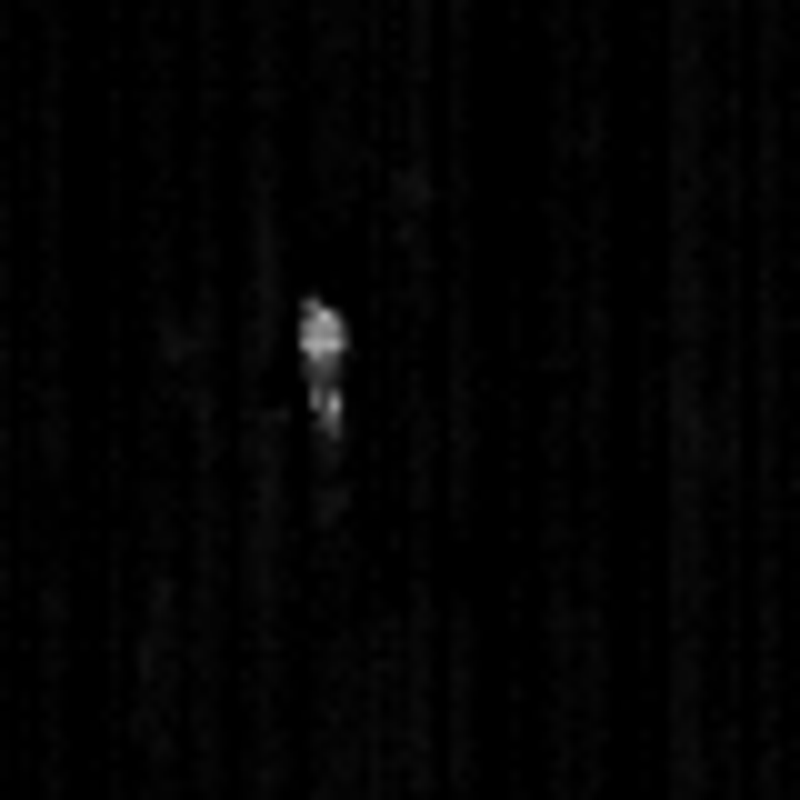

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1

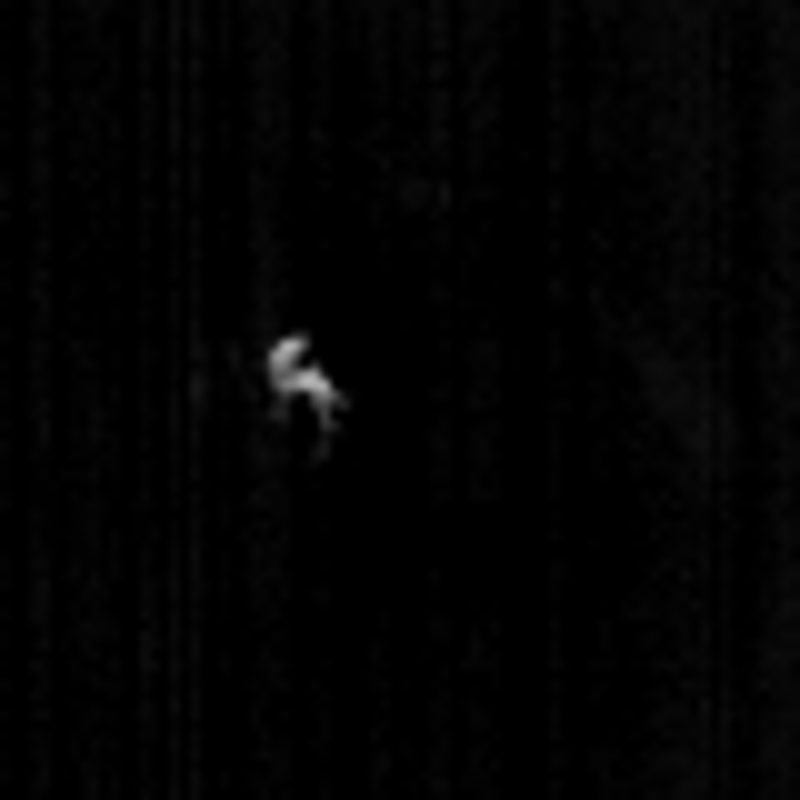

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 

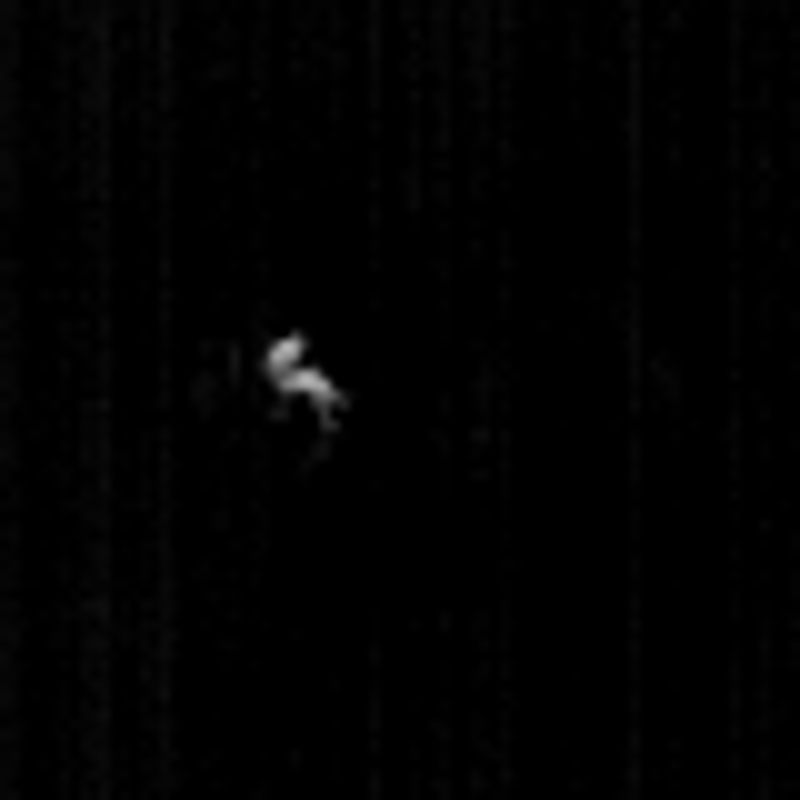

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.1 0.2 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0

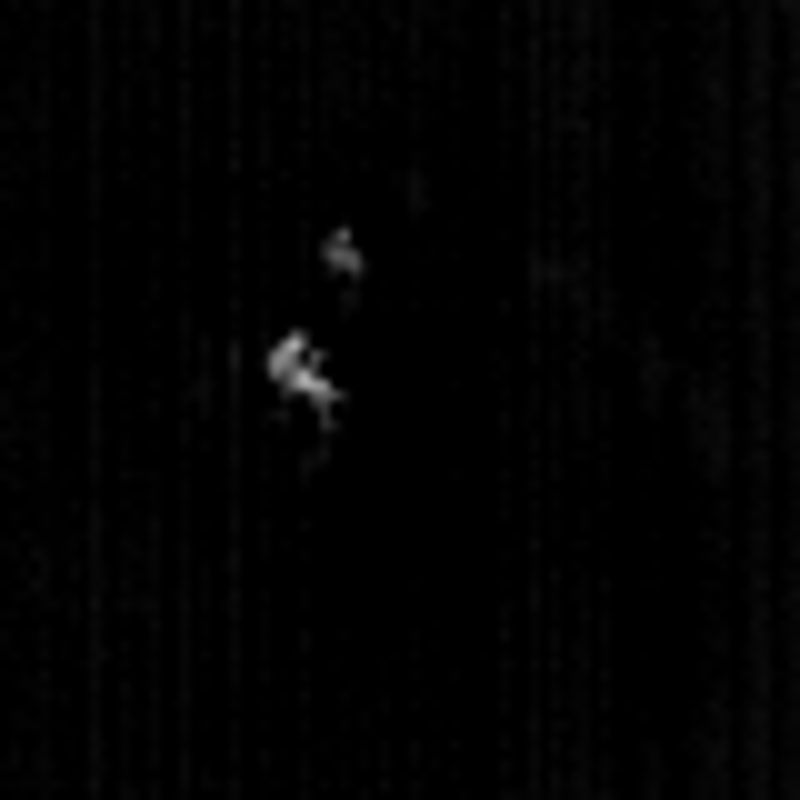

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.  0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1
 0.1 0.1]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1
 0.1 0. ]
[0.  0.1 0.2 0.2 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 

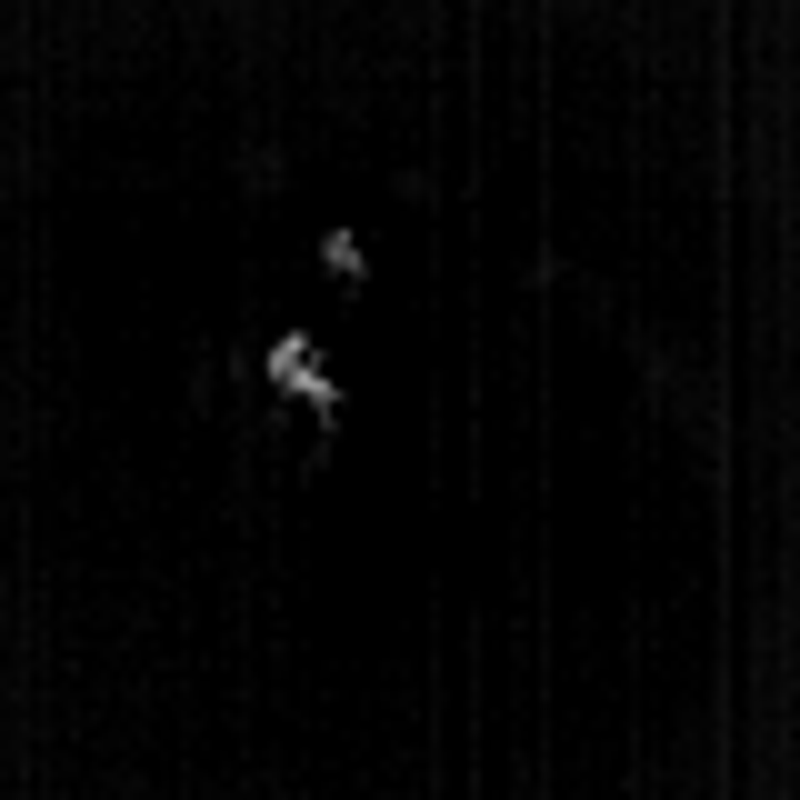

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1

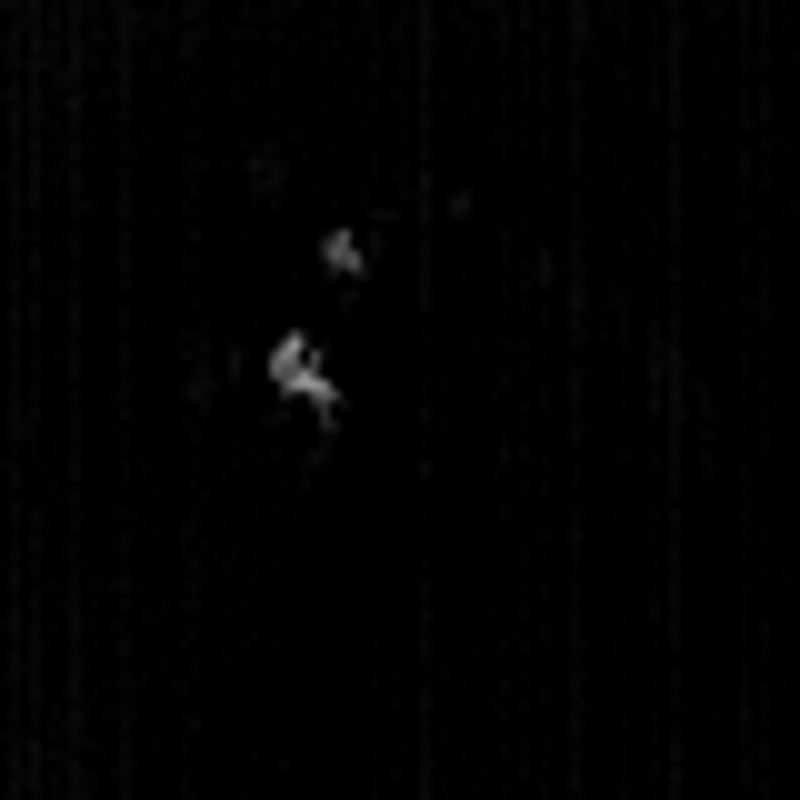

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1

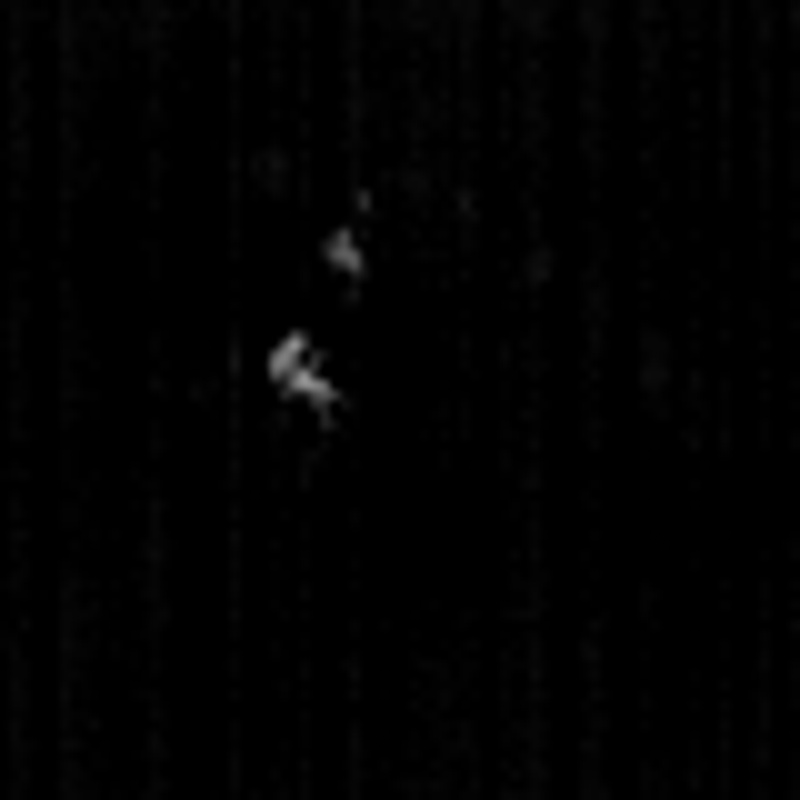

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 

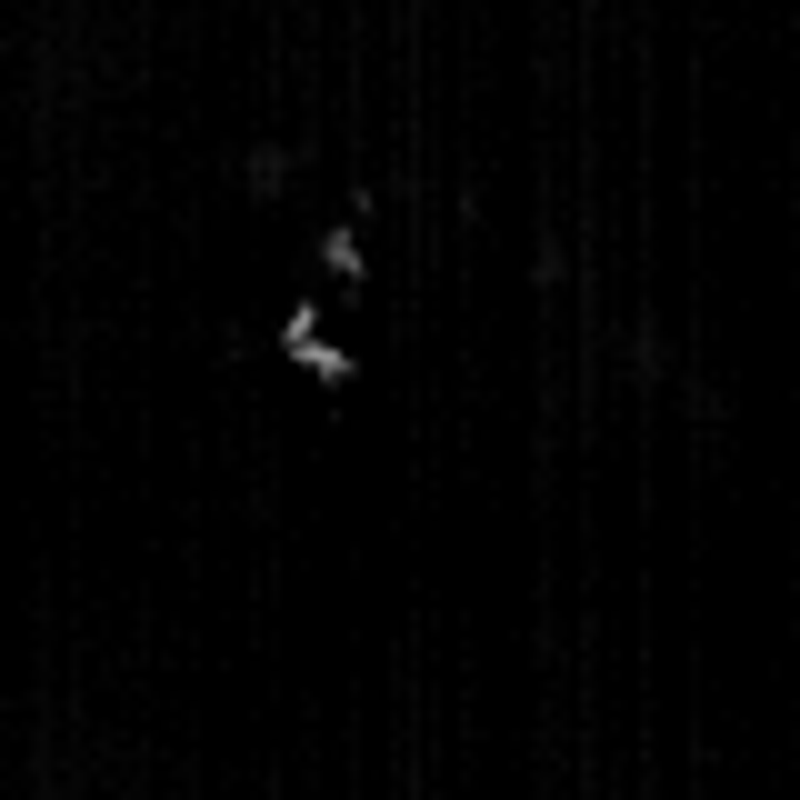

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1

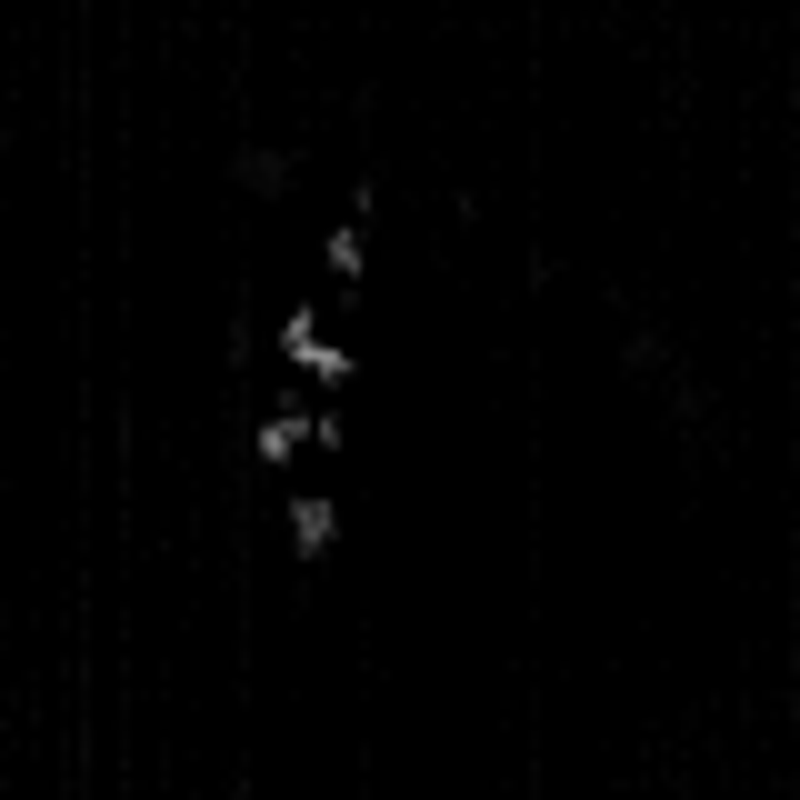

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2

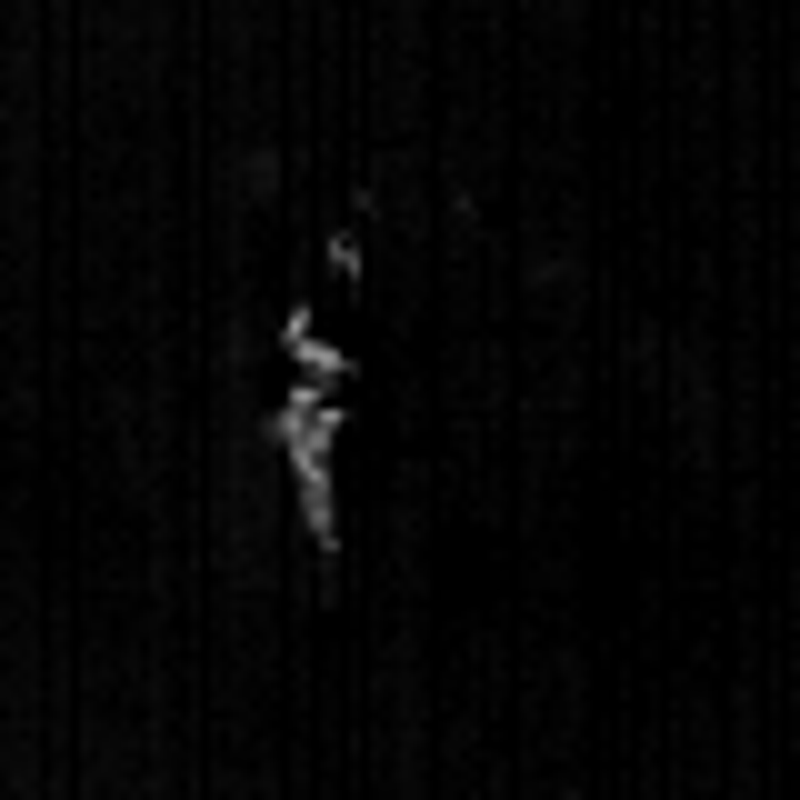

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.1 0.  0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2

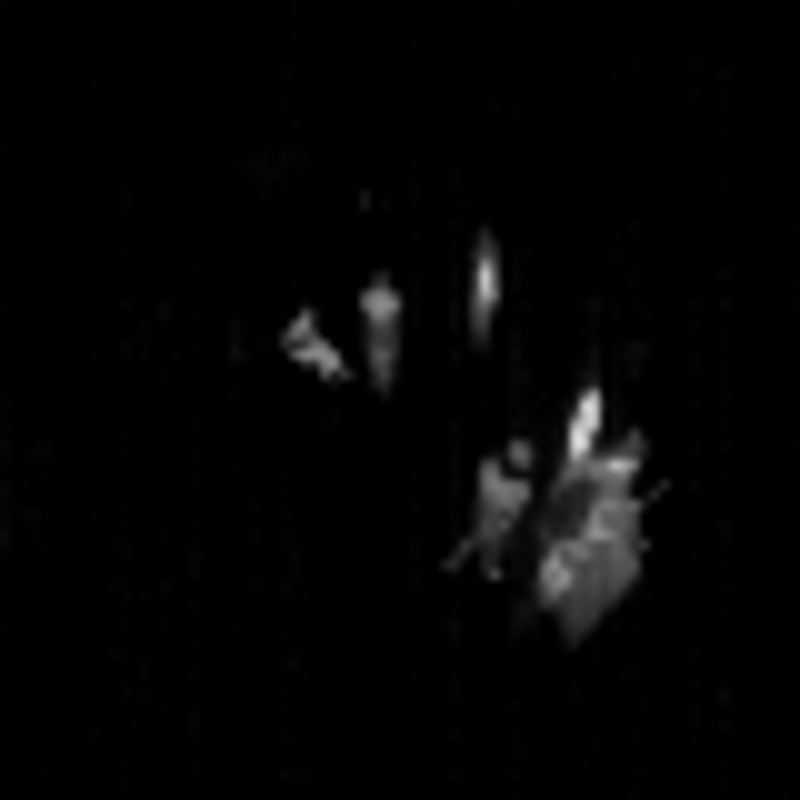

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2
 0.2 0.1]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.1]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.1 0.1]
[0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0.1]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]
[0.  0.  0.1 

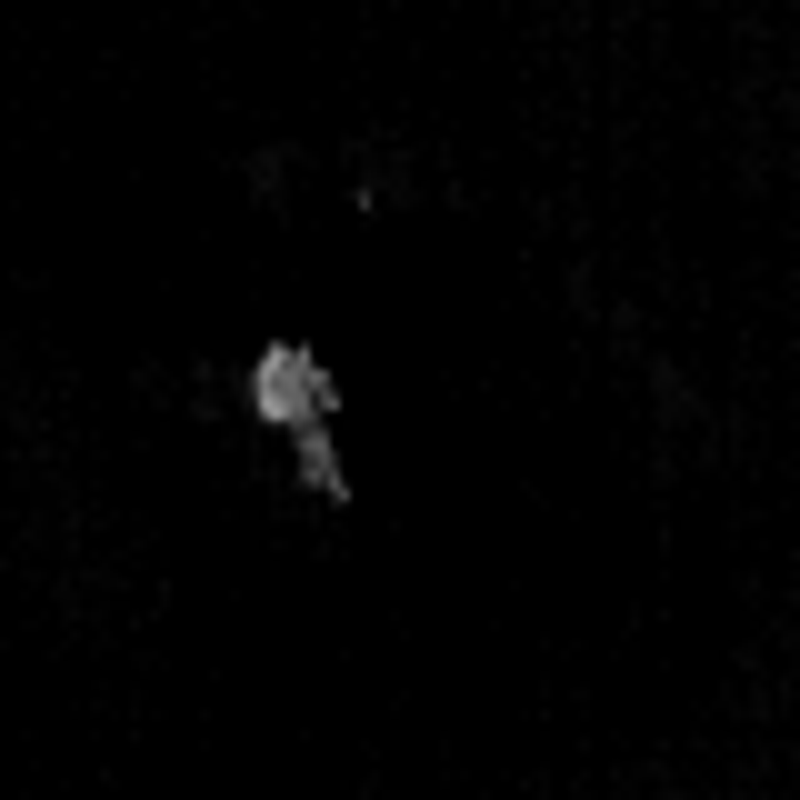

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0

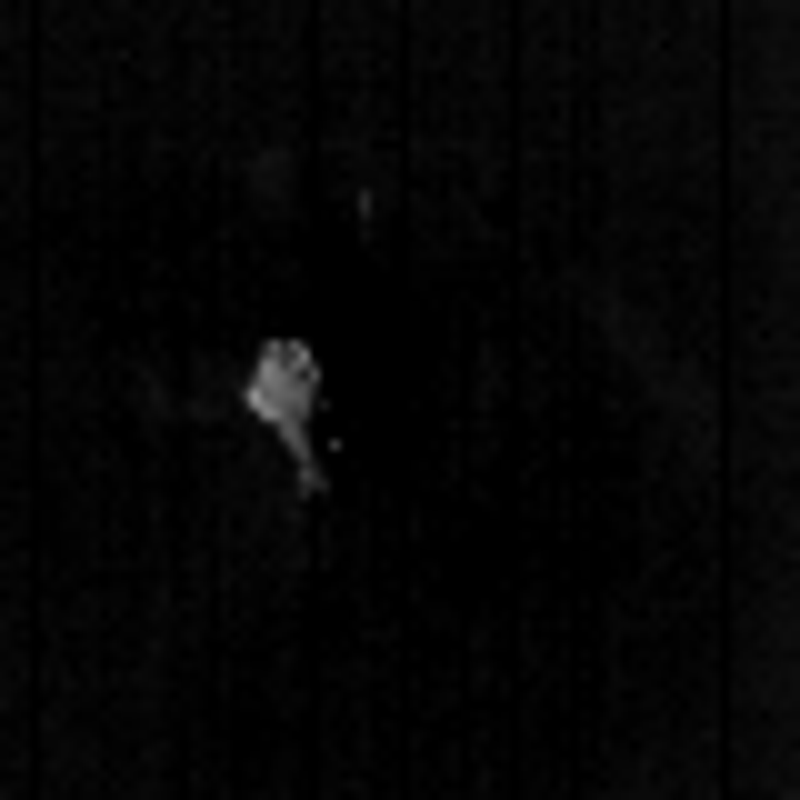

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1

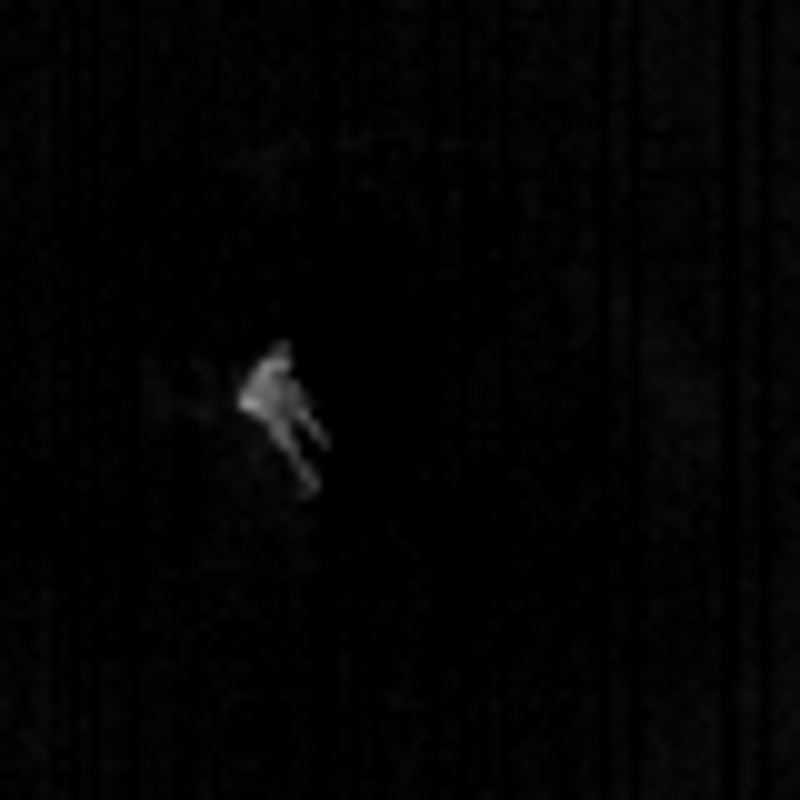

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2

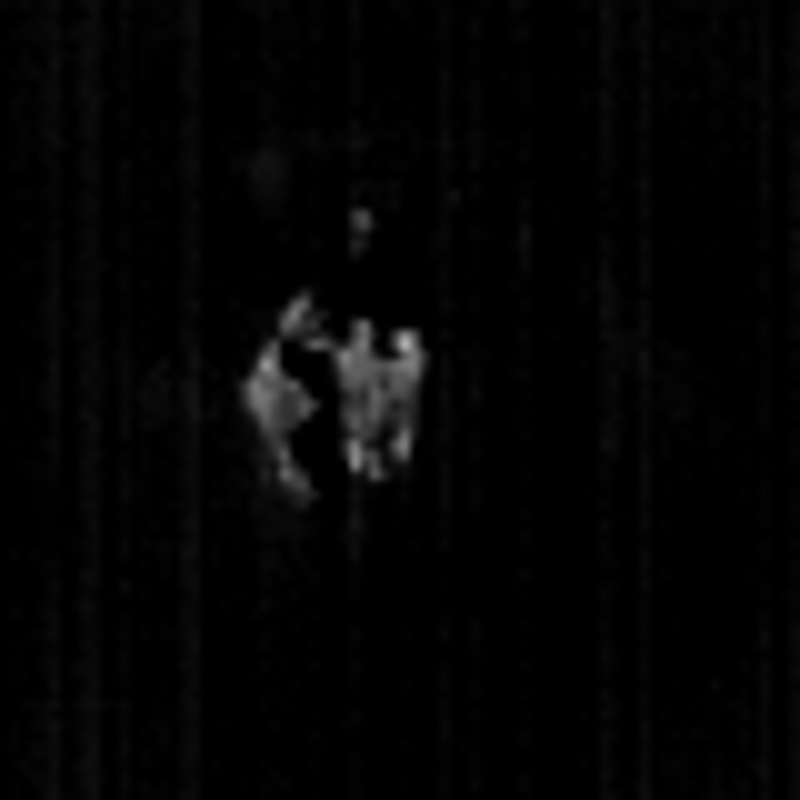

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.1 0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.1
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 

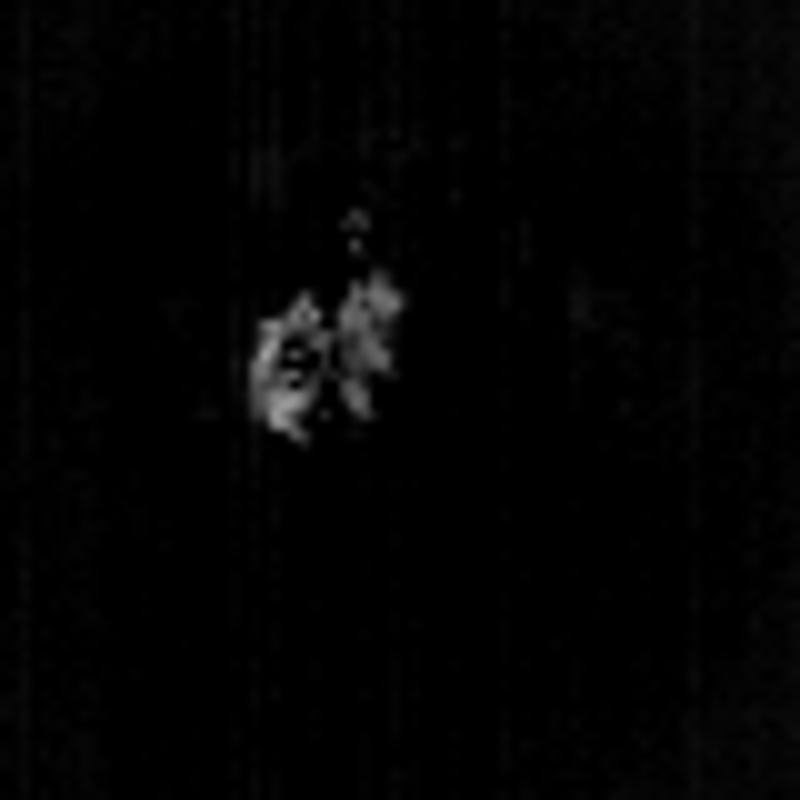

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.  0.  0.  0.1
 0.1 0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.

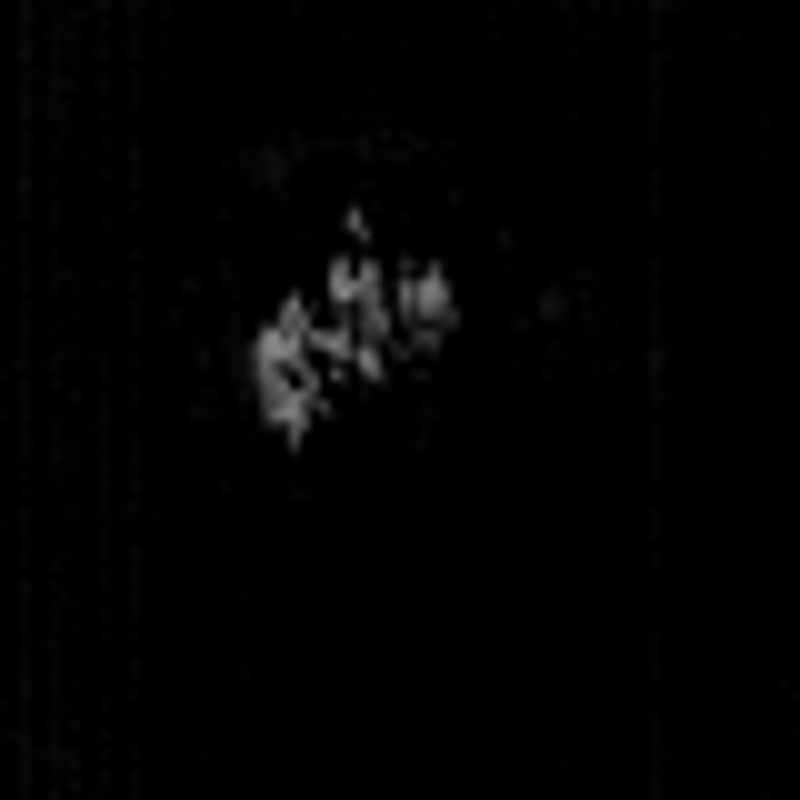

predicted:

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0.1]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0.1]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.1
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.  0.  0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.1
 0.  0

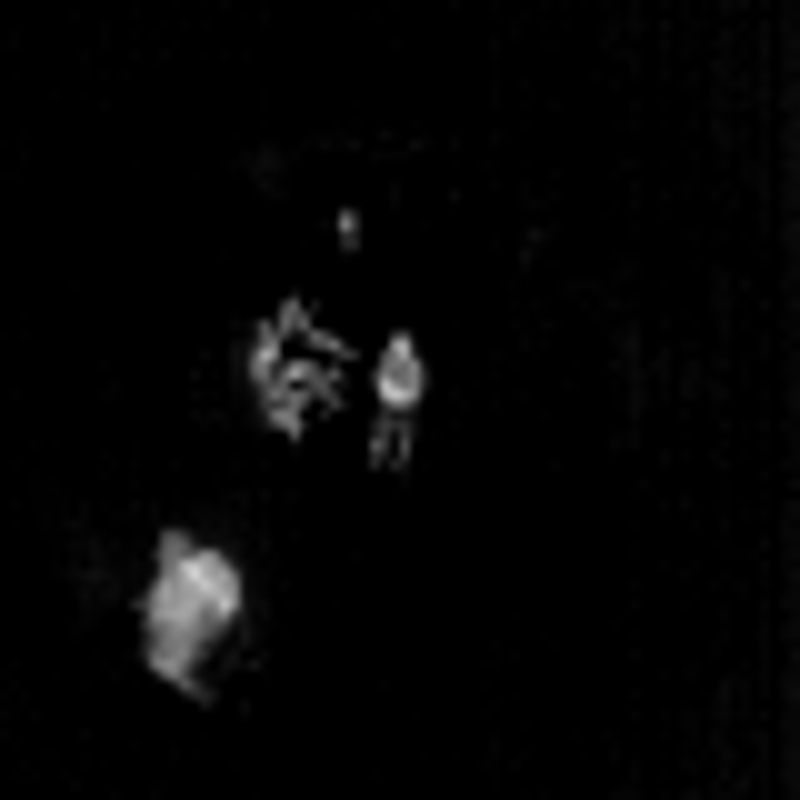

predicted:

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.  0.  0.  0.
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1
 0.1 0.1

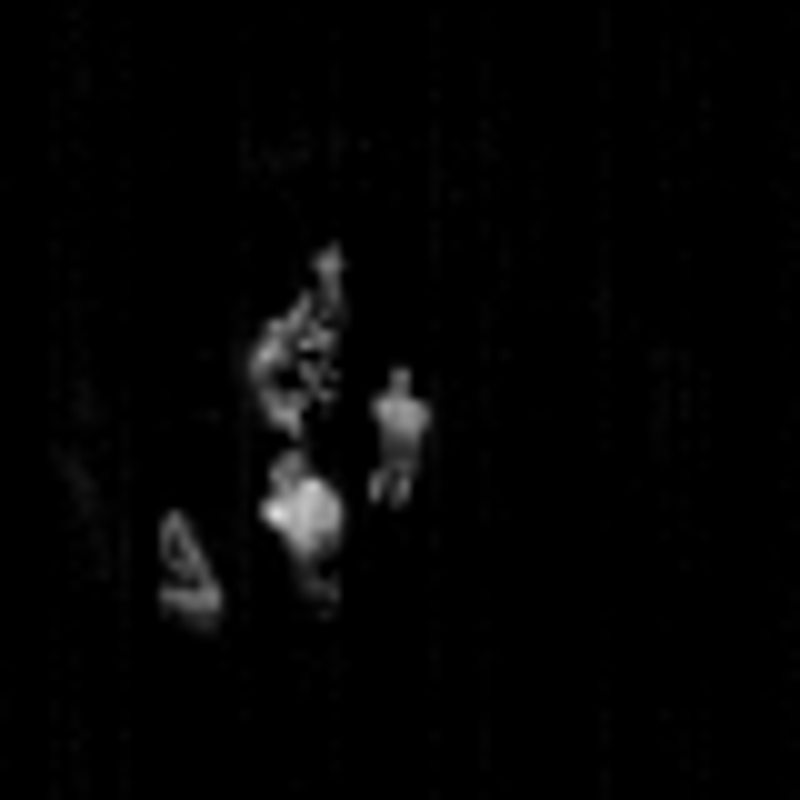

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0.1]
[0.1 0.2 0.2 0.2 0

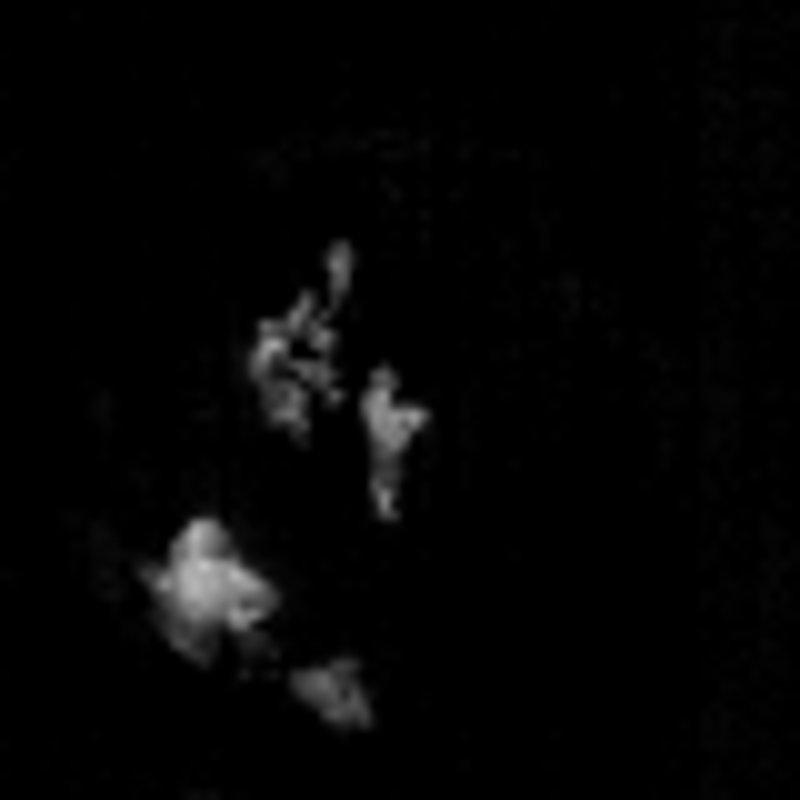

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.1 0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.1 0.1]
[0.1 0.1 0.2 0.2 0.2

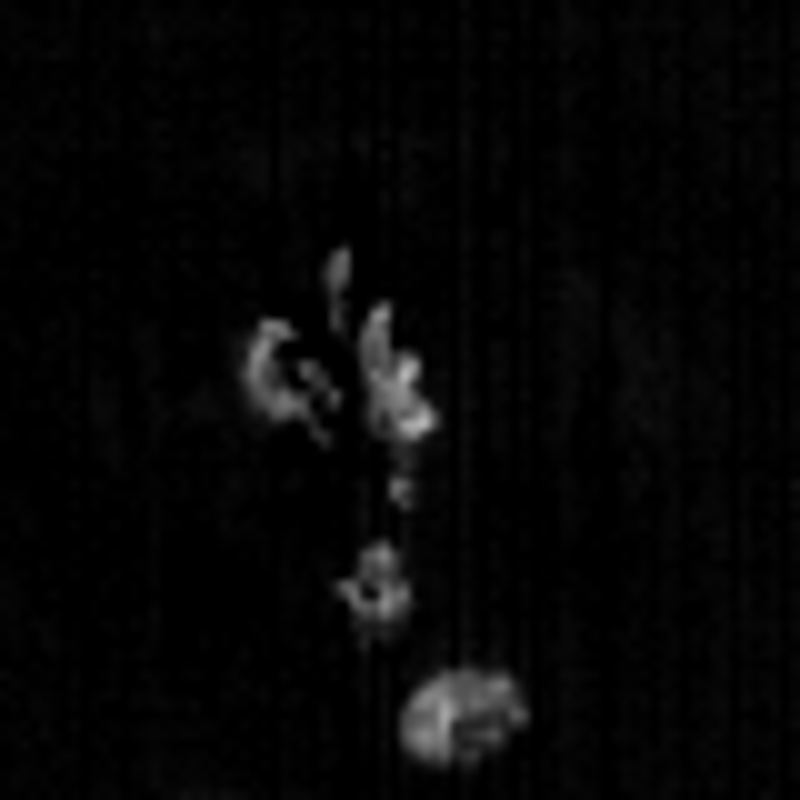

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.  0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.  0.  0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1
 0.  0. ]
[0.  0.  0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0

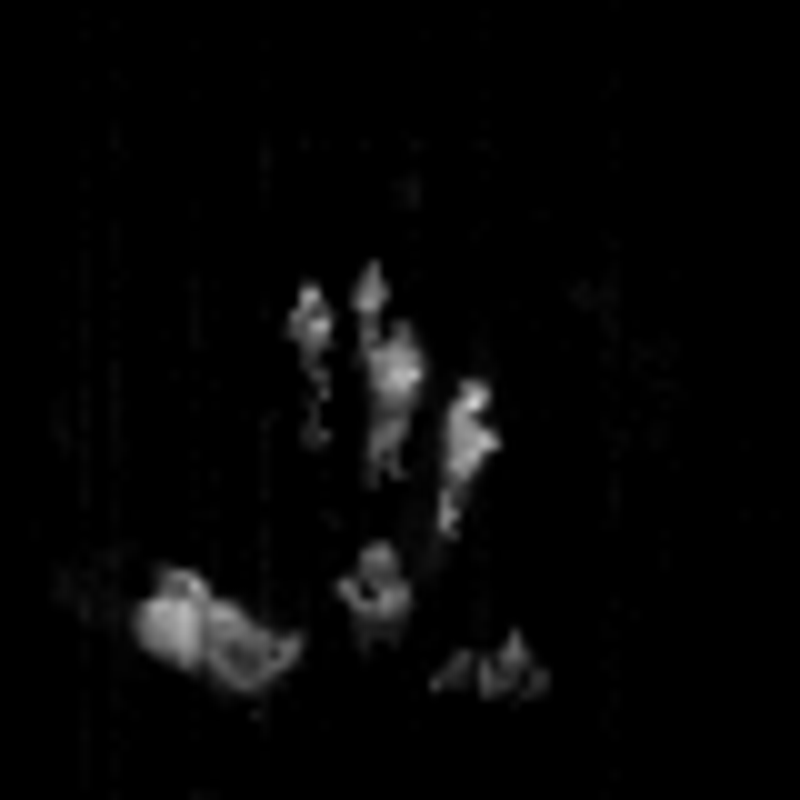

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.1 0.1]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2
 0.1 0.1]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2
 0.1 0.1]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2
 0.1 0.1]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.1]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.1]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.1 0.1]
[0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1
 0.1 0. ]
[0.1 0.1 0.1 

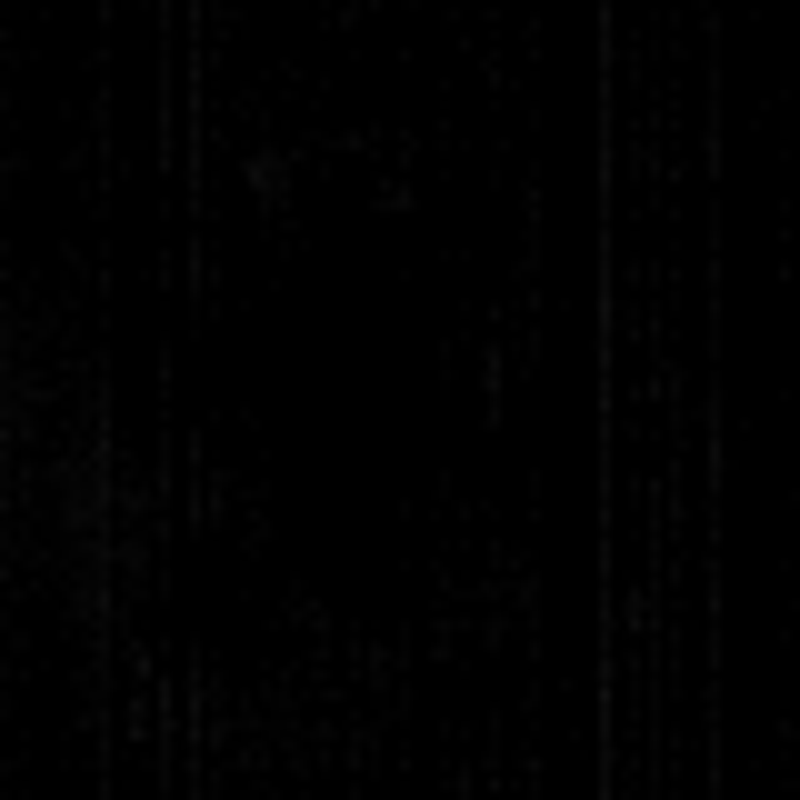

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.  0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.1 0.1
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

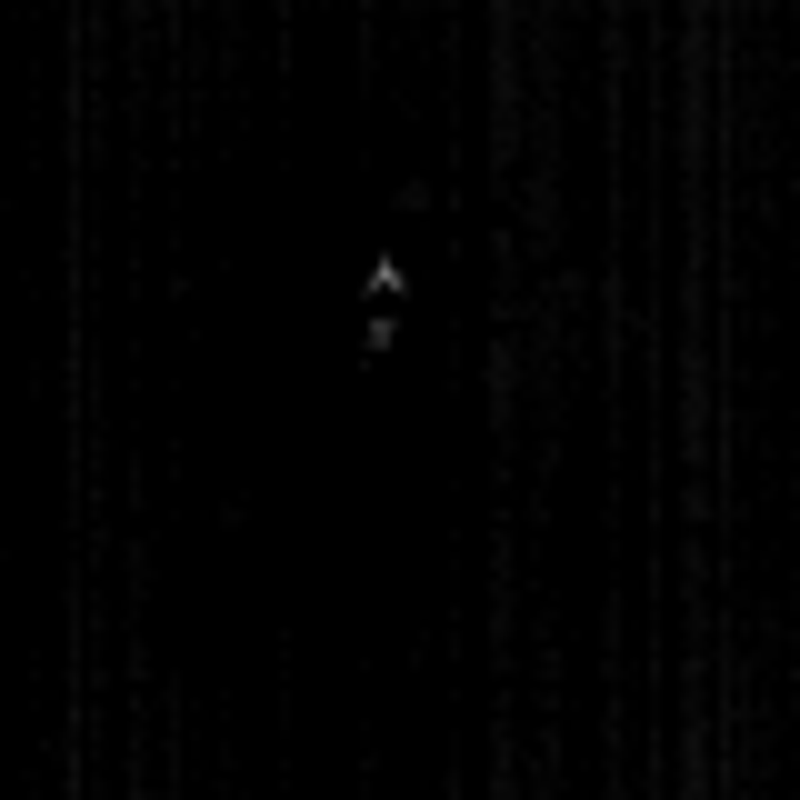

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0

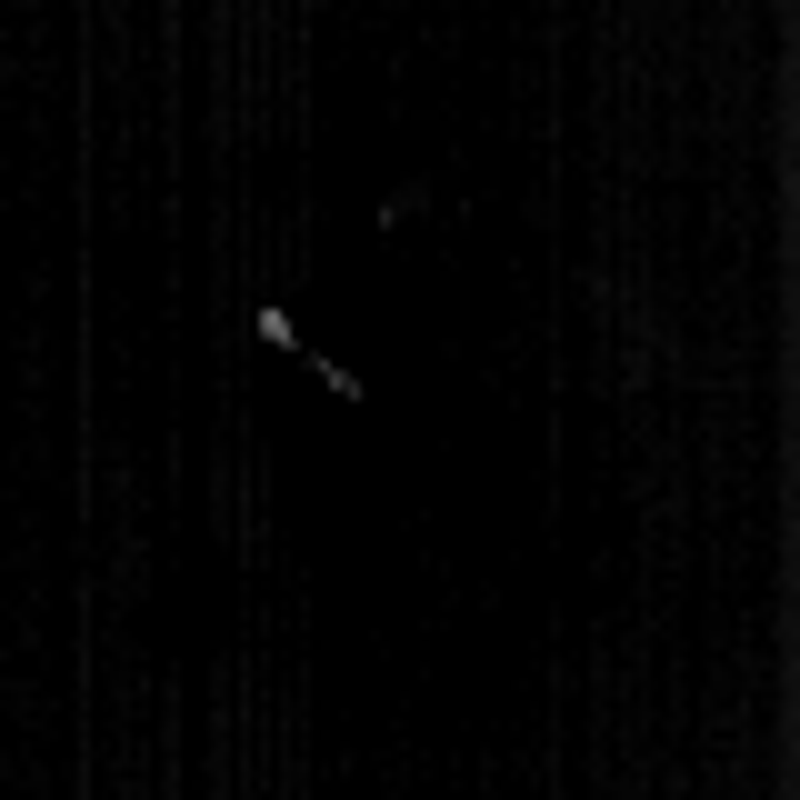

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0

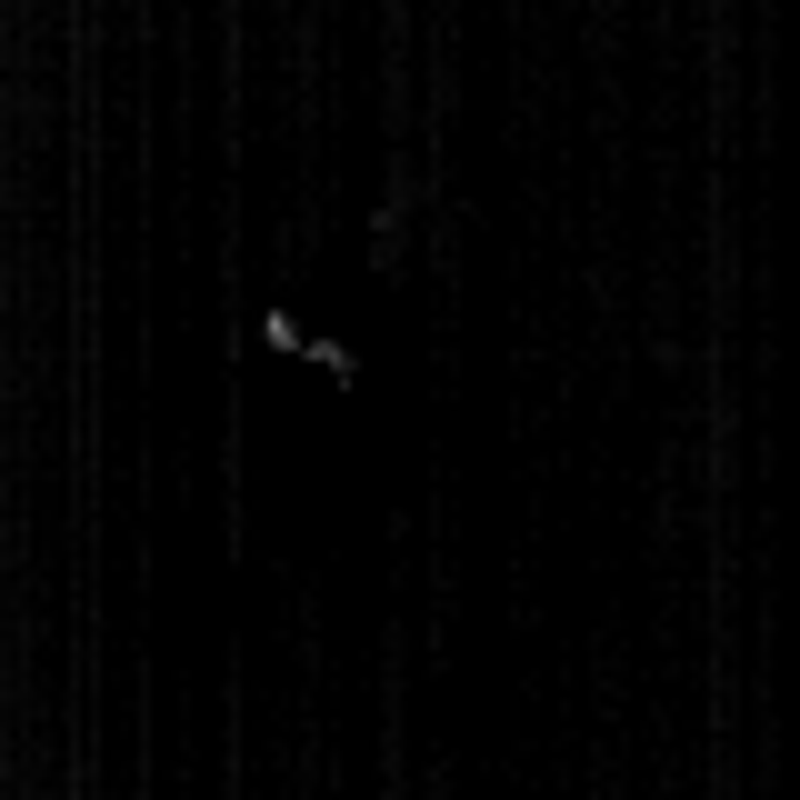

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1

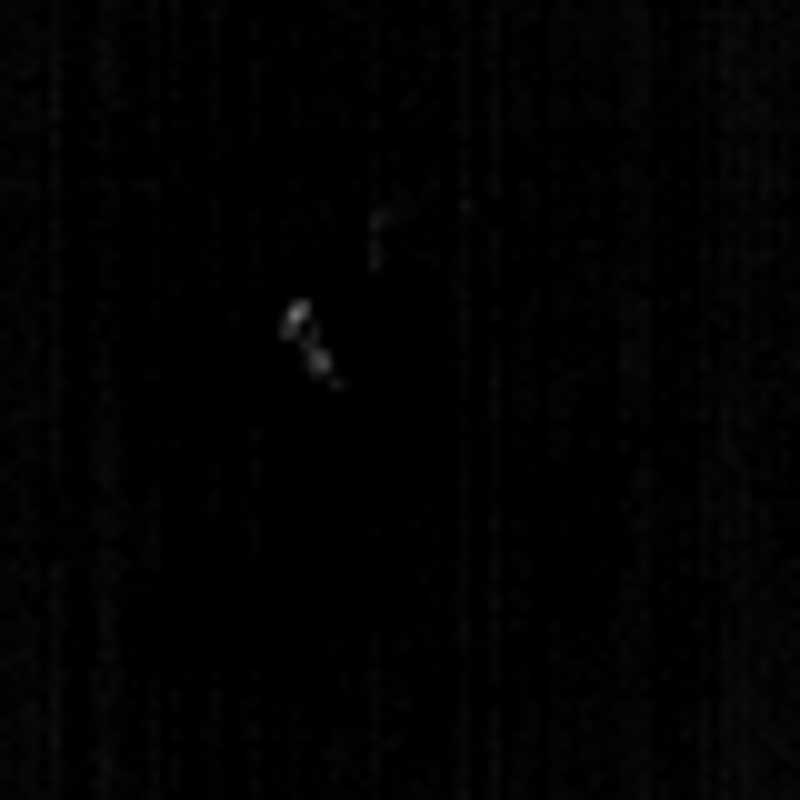

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 

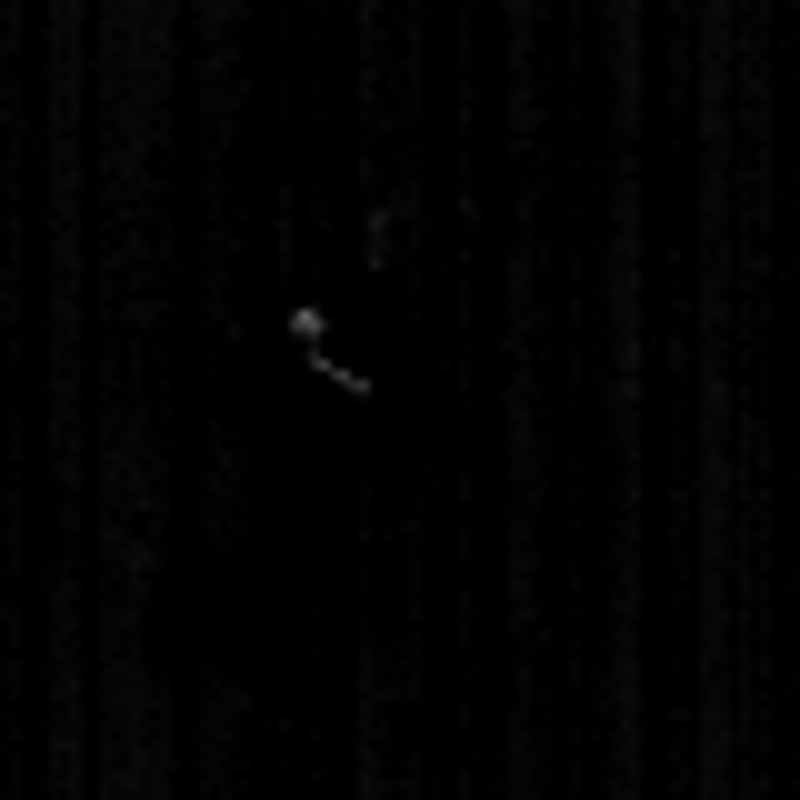

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1

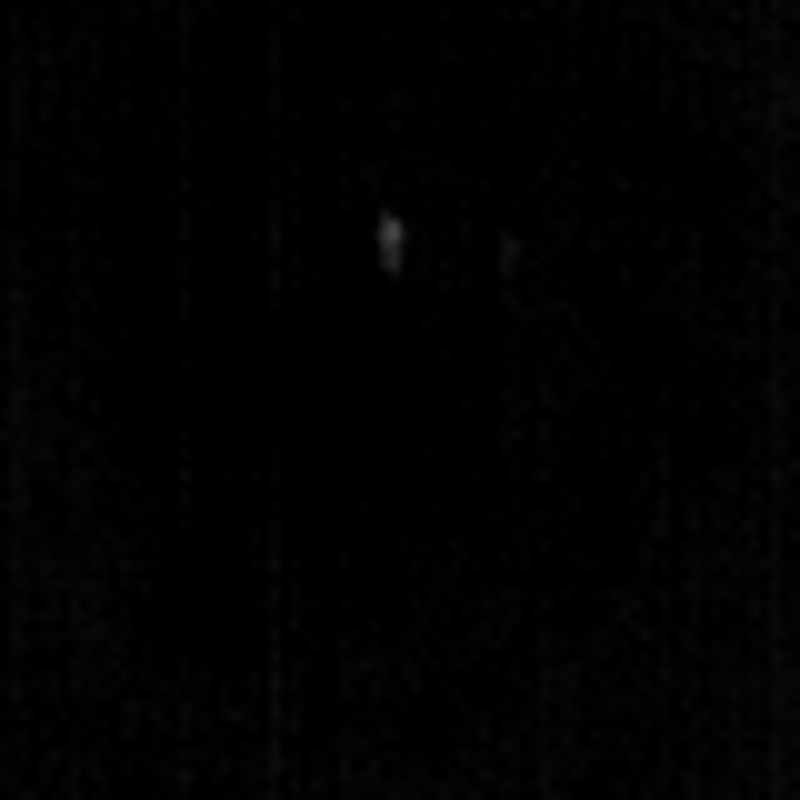

predicted:

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.2 0.1 0.1 0.1 0.  0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1
 0.1 0. ]
[0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.2 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. 

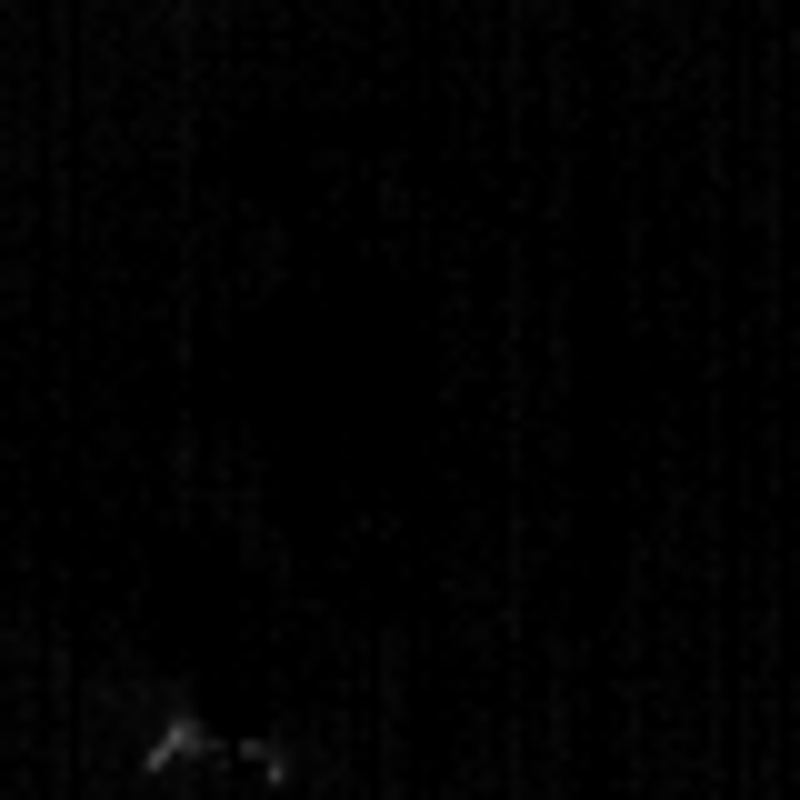

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1
 0.1 0.1]
[0.  0.  0.  0.  0.  

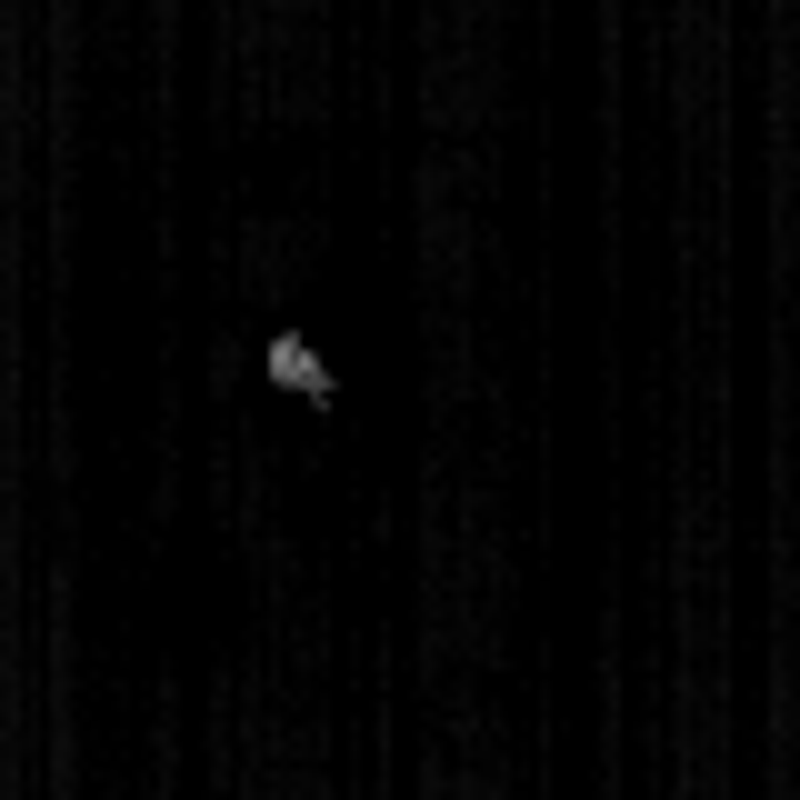

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.1 0.1 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.1

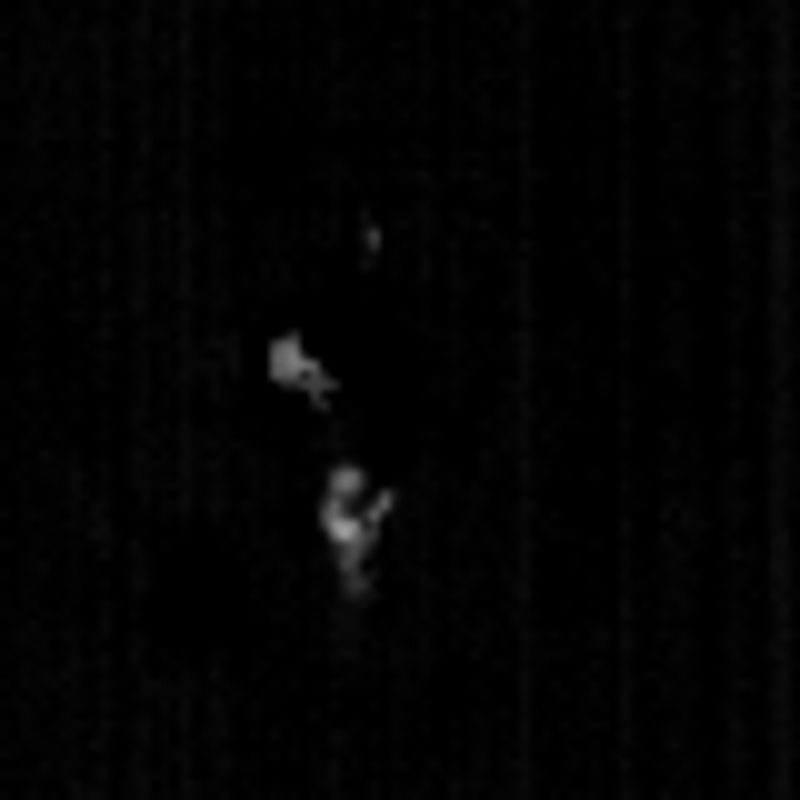

predicted:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.1 0.1 0.1 0.  0.  0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.  0. ]
[0.  0.  0.1 0.1 0.  0.  0.  0.1 0.1 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.1 0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.1 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.  0.1 0.2 0.2 0.3 0.3 0.3 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.1 0.1 0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.1 0.1 0.  0.  0.
 0.  0. ]
[0.  0.  0.1 0.2 0.2 0.

In [46]:
predict_shaped1 = predict_shaped
N = 10
# N = len(predicted)
for i in range(620,660):
    size = 10
    test_img = Image.fromarray((X2[i]*255).reshape(H,W)).convert('L').resize((W*size, H*size))
    display(test_img)

    for j, k in enumerate(predict_shaped1[i]):
        if k < 0.1:
            predict_shaped1[i,j] = 0
    # predict_shaped[i] = [predict_shaped[i,j] = 0 for j,k in enumerate(predict_shaped[i]) if k < 0.1]
    log(DEBUG, f"predicted:{chr(10)}")
    cnt1 = 0
    for line in range(20):
        li = np.round(predict_shaped1[i,cnt1:cnt1+20], 1)
        # li = predict_shaped1[i, cnt1:cnt1+20]
        log(DEBUG, f"{li}")
        cnt1 += 20
    cnt1 = 0
    log(DEBUG, f"{chr(10)}label:{chr(10)}")
    cnt2 = 0
    for line in range(20):
        log(DEBUG, f"{Y2_shaped[i,cnt2:cnt2+20]}")
        cnt2 += 20
    cnt2 = 0

    # log(DEBUG, f"total_difference: {len(abs(predict_shaped[i]-Y2_shaped[i]))}")
    # log(DEBUG, f"difference: {abs(predict_shaped[i]-Y2_shaped[i])}")
